PyMC Version: 5.25.1
ArviZ Version: 0.22.0
Data loaded successfully.
Sampling from the posterior distribution...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma]


d:\10academy\week_10_change_point_analysis_and_statistical_modelling_of_time_series_data\.venv\Lib\site-packages\ri
ch\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 85330 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Model Summary:
              mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau        4519.91  3.18  4513.00  4525.00        0.1     0.08    946.37   
mu_before    21.50  0.28    20.99    22.03        0.0     0.00   5875.55   
mu_after     75.52  0.28    74.97    76.04        0.0     0.00   5963.97   
sigma        18.58  0.14    18.32    18.84        0.0     0.00   5618.68   

           ess_tail  r_hat  
tau          896.03    1.0  
mu_before   3272.39    1.0  
mu_after    3139.25    1.0  
sigma       3129.32    1.0  


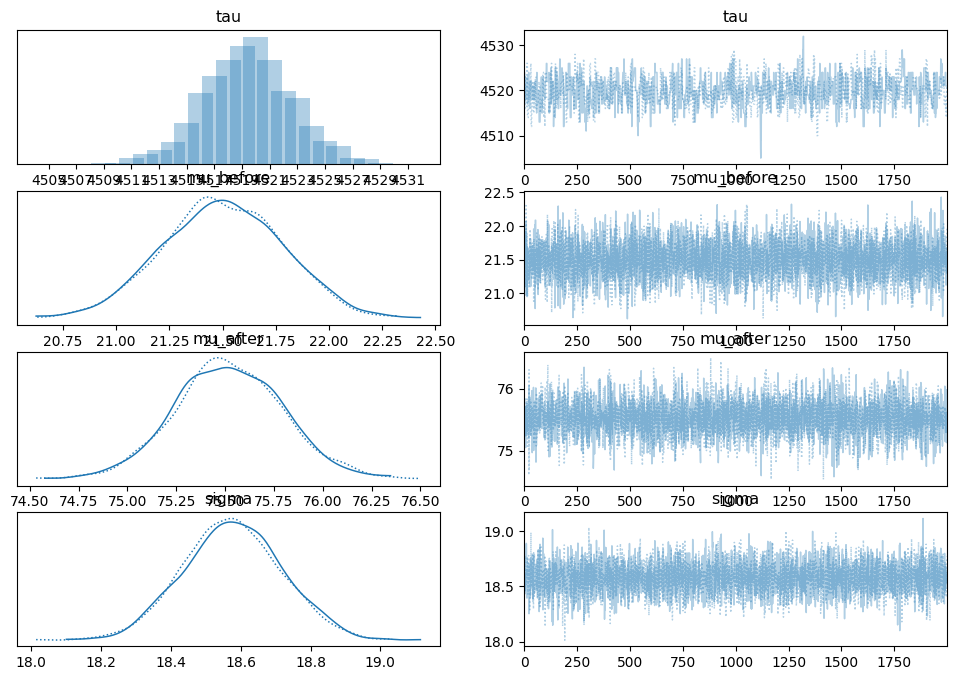

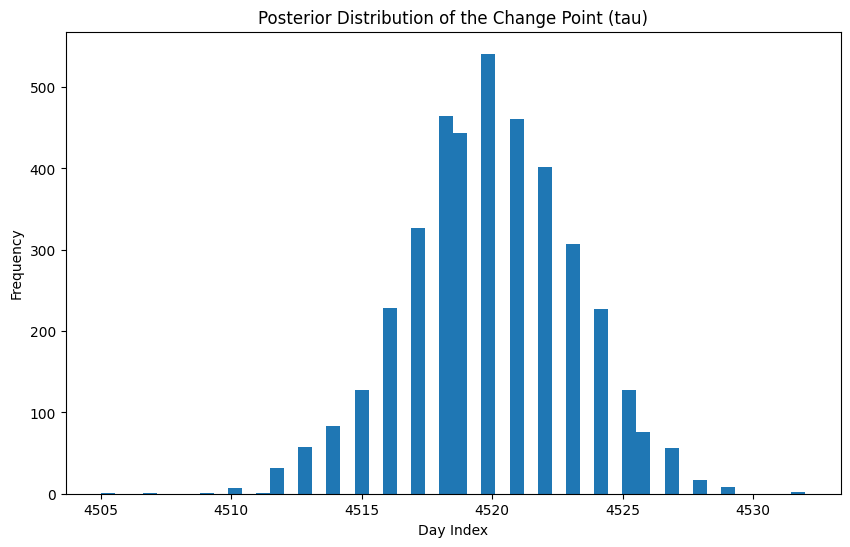

The most probable change point occurred on: 2005-02-23


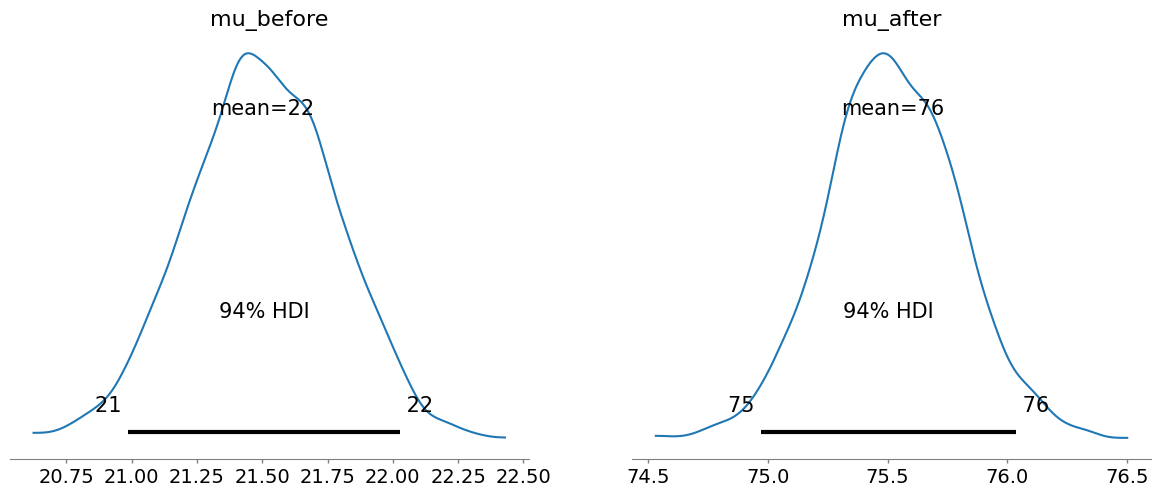


Saving analysis results for the dashboard...
Analysis results saved to ../data/processed/analysis_results.json


In [5]:

# This cell sets up the environment and loads the necessary data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import json

print(f"PyMC Version: {pm.__version__}")
print(f"ArviZ Version: {az.__version__}")

# Load the cleaned data and events data from Task 1
try:
    brent_prices_df = pd.read_csv('../data/processed/brent_prices_cleaned.csv', index_col='Date', parse_dates=True)
    events_df = pd.read_csv('../data/processed/geopolitical_events.csv', parse_dates=['event_date'])

    # Extract the prices for modeling
    prices = brent_prices_df['Price'].values

    # The size of our dataset
    N = prices.shape[0]

    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Ensure that the data ingestion and event research scripts from Task 1 have been run.")
    print("Files 'brent_prices_cleaned.csv' and 'geopolitical_events.csv' are required in '../data/processed/'.")



# This model assumes the mean of the prices changes at a specific, unknown point in time.
with pm.Model() as oil_price_model:

    # 1. Define the switch point (tau)
    # A discrete uniform prior over all possible days in the dataset.
    tau = pm.DiscreteUniform('tau', lower=0, upper=N)

    # 2. Define the "Before" and "After" parameters (mean and standard deviation)
    # The mean prices before and after the change point
    mu_before = pm.Normal('mu_before', mu=prices.mean(), sigma=5)
    mu_after = pm.Normal('mu_after', mu=prices.mean(), sigma=5)

    # The standard deviation (volatility) of the prices
    # Use an Exponential distribution for standard deviation as it must be positive.
    sigma = pm.Exponential('sigma', lam=1)

    # 3. Use a switch function to select the correct mean based on tau
    # The `pm.math.switch` function will select mu_before if the index is < tau,
    # and mu_after if the index is >= tau.
    mu = pm.math.switch(tau >= np.arange(N), mu_before, mu_after)

    # 4. Define the likelihood: connect the model to the data
    # The observed prices are assumed to be normally distributed around the mean.
    observation = pm.Normal('observation', mu=mu, sigma=sigma, observed=prices)

    # 5. Run the sampler (MCMC simulation)
    # This is the line that creates the 'idata' variable.
    print("Sampling from the posterior distribution...")
    idata = pm.sample(draws=2000, tune=1000, cores=2, return_inferencedata=True)



# This cell visualizes the results of the MCMC sampling and saves them to a file.
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import json

print("\nModel Summary:")
print(az.summary(idata, round_to=2))

# Plot the trace to check for sampling convergence
az.plot_trace(idata)
plt.show()

# Identify the change point (tau) by plotting its posterior distribution
tau_samples = idata.posterior['tau'].values.flatten()
plt.figure(figsize=(10, 6))
plt.hist(tau_samples, bins=50)
plt.title('Posterior Distribution of the Change Point (tau)')
plt.xlabel('Day Index')
plt.ylabel('Frequency')
plt.show()

# Get the most probable change point date
most_probable_tau = pd.Series(tau_samples).mode()[0]
change_point_date = brent_prices_df.index[most_probable_tau]
print(f"The most probable change point occurred on: {change_point_date.strftime('%Y-%m-%d')}")

# Visualize the impact (before vs. after prices)
az.plot_posterior(idata, var_names=['mu_before', 'mu_after'])
plt.show()

# --- Corrected Code to Save Results to JSON ---
print("\nSaving analysis results for the dashboard...")

# Get the most probable change point date and its index
mu_before_mean = az.summary(idata, var_names=['mu_before']).mean()['mean']
mu_after_mean = az.summary(idata, var_names=['mu_after']).mean()['mean']

# Convert DataFrames to dictionaries with date strings
historical_prices_dict = brent_prices_df.reset_index().copy()
historical_prices_dict['Date'] = historical_prices_dict['Date'].dt.strftime('%Y-%m-%d')
historical_prices_dict = historical_prices_dict.to_dict('records')

geopolitical_events_dict = events_df.copy()
geopolitical_events_dict['event_date'] = geopolitical_events_dict['event_date'].dt.strftime('%Y-%m-%d')
geopolitical_events_dict = geopolitical_events_dict.to_dict('records')

# Compile all analysis results into a dictionary
analysis_results = {
    "historical_prices": historical_prices_dict,
    "change_point": {
        "index": int(most_probable_tau),
        "date": change_point_date.strftime('%Y-%m-%d'),
        "mu_before_mean": float(mu_before_mean),
        "mu_after_mean": float(mu_after_mean),
    },
    "geopolitical_events": geopolitical_events_dict
}

# Save the results to a JSON file in the correct directory
output_file = "../data/processed/analysis_results.json"
with open(output_file, 'w') as f:
    json.dump(analysis_results, f, indent=4)

print(f"Analysis results saved to {output_file}")